In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('bright')

In [2]:
#Reading in data, here I have two csv files containing records from different dates
df1=pd.read_csv('C:/Users/Rory/Downloads/price_paid_records.csv',index_col = 'Transaction unique identifier')
df1['Date of Transfer'] = pd.to_datetime(df1['Date of Transfer'])
df2=pd.read_csv('C:/Users/Rory/Downloads/ppd_data.csv',index_col = 'unique_id')
df2['deed_date']=pd.to_datetime(df2['deed_date'])
df2=df2.rename(columns={"price_paid":"Price", "deed_date":"Date","property_type":"Type"})
df1=df1.rename(columns={"Date of Transfer":"Date","Property Type":"Type"})

In [3]:
#Removing all house sales not in Cardiff
notcardiff=df1[df1['County']!='CARDIFF'].index
df1.drop(notcardiff, inplace=True)
(df1['County']== 'CARDIFF').value_counts()

True    134115
Name: County, dtype: int64

In [4]:
#Removing all property sales which are not terrace houses
notterrace1=df1[df1['Type']!='T'].index
df1.drop(notterrace1, inplace=True)
notterrace2=df2[df2['Type']!='T'].index
df2.drop(notterrace2, inplace=True)

In [5]:
# Now since all property sales are in Cardiff and terrace houses, we can drop all columns but price and date
df1=df1[['Price','Date']]
df1['Date2']=df1['Date']
df1.index.name='index_no'
df2=df2[['Price','Date']]
df2['Date2']=df2['Date']
df2.index.name='index_no'

In [6]:
# Concatenating both dataframes into a single dataframe 
df=pd.concat([df1,df2])
df.index.drop_duplicates(keep=False);
# Keeping a reference dataframe
df_old=df.copy()

No handles with labels found to put in legend.


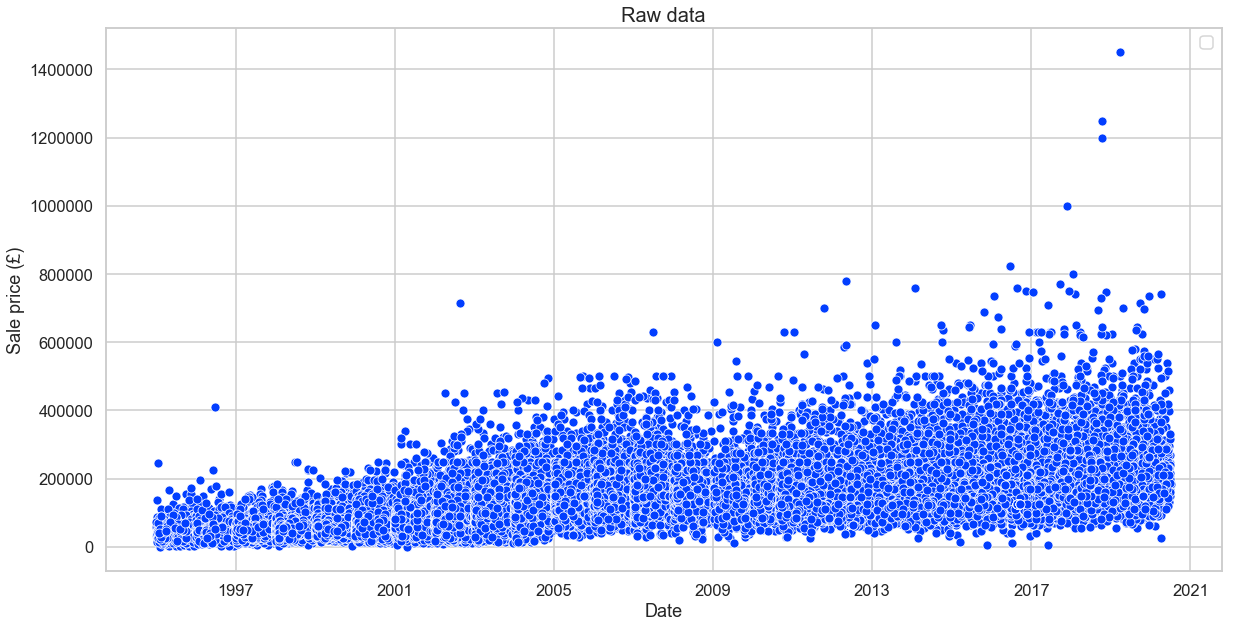

In [7]:
#Scatter plot of price and date over a decade
plt.figure(figsize=(20,10))
ax=sns.scatterplot(x="Date", y="Price", data=df);
plt.xlabel("Date", fontsize='18')
plt.ylabel("Sale price (£)", fontsize='18')
plt.title("Raw data", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [8]:
#Outlier removal - lets get rid of those million pound houses.....

df['Year']=df['Date'].dt.year
outliers=[]
threshold=3
yr_median=pd.DataFrame(df.groupby(['Year'], as_index=False)['Price'].median().set_index('Year'))
yr_std=pd.DataFrame(df.groupby(['Year'], as_index=False).agg({'Price':['std']}).set_index('Year'))

#Searching for the outliers
for d in df['Year'].unique():                
    for label, row in df.iterrows():
        if row['Year']==d:
            z_score= np.divide(np.subtract(row['Price'], (yr_median.values[yr_median.index==d])),(yr_std.values[yr_std.index==d]))
            if np.abs(z_score) > threshold:
                outliers.append(label)
        
#Removing outliers from the dataframe
for i in outliers:
    df.drop(i , inplace=True)




Text(0.5,1,'Post-outlier removal')

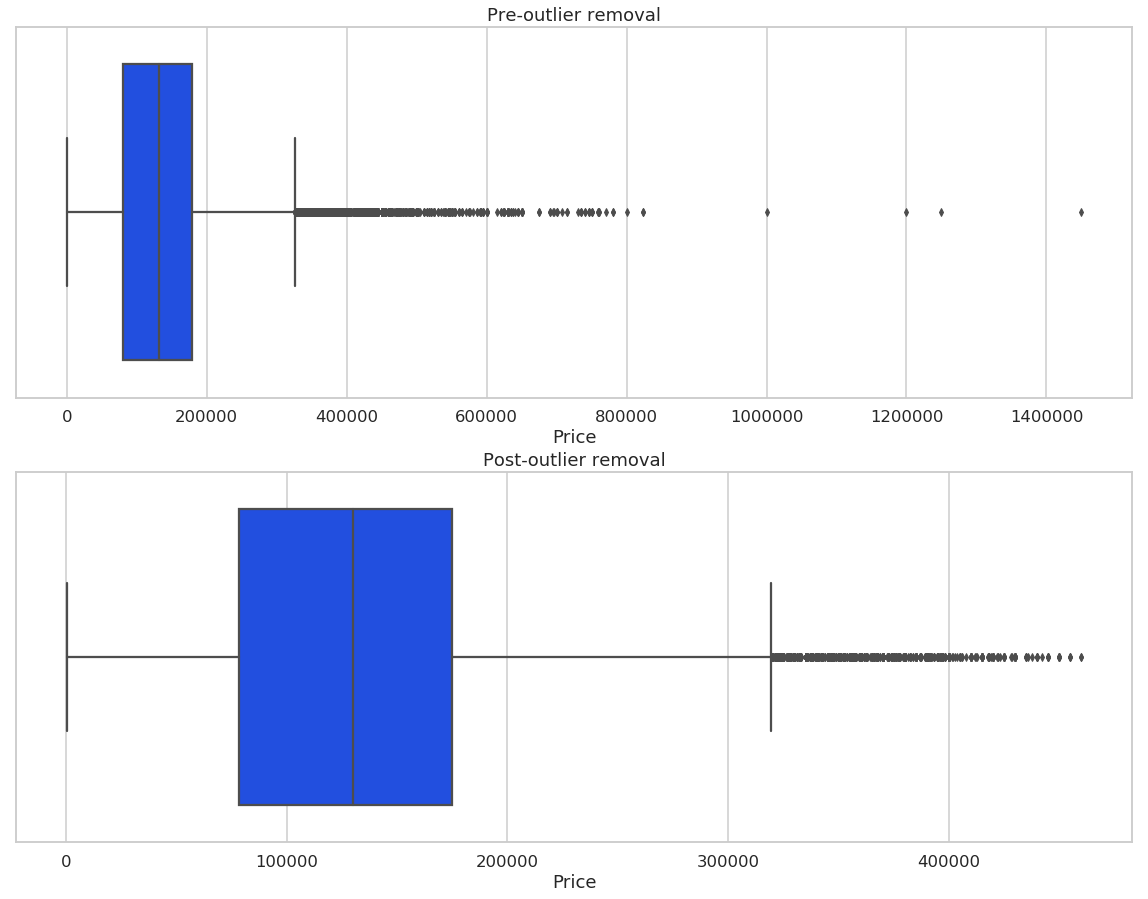

In [9]:
f, axes=plt.subplots(2,1, figsize=(20,15))
sns.boxplot(x="Price", data=df_old, ax=axes[0]).set_title('Pre-outlier removal')
sns.boxplot(x="Price", data=df, ax=axes[1]).set_title('Post-outlier removal')

In [10]:

df.head()

,Price,Date,Date2,Year
index_no,,,,
{742E87B7-5134-487D-8370-1E456AACB593},35450,1995-07-14,1995-07-14,1995
{D32149A0-38C6-4941-B288-423F13479616},43500,1995-12-07,1995-12-07,1995
{24DF25B8-94E7-41A3-9356-554B70405C36},21000,1995-10-26,1995-10-26,1995
{CB8C758E-8EE7-4B8B-88CA-58C34A33B833},28700,1995-10-20,1995-10-20,1995
{0DB1DE63-226D-4A0B-867A-58C5E8336201},31000,1995-11-30,1995-11-30,1995


In [11]:
# Creating a time-series by calculating mean house sale prices for each month
df=df[['Price','Date']].reset_index()
df=df.set_index('Date')
df=df[['Price']]
ts=df.resample('m').mean()
ts=ts['Price']


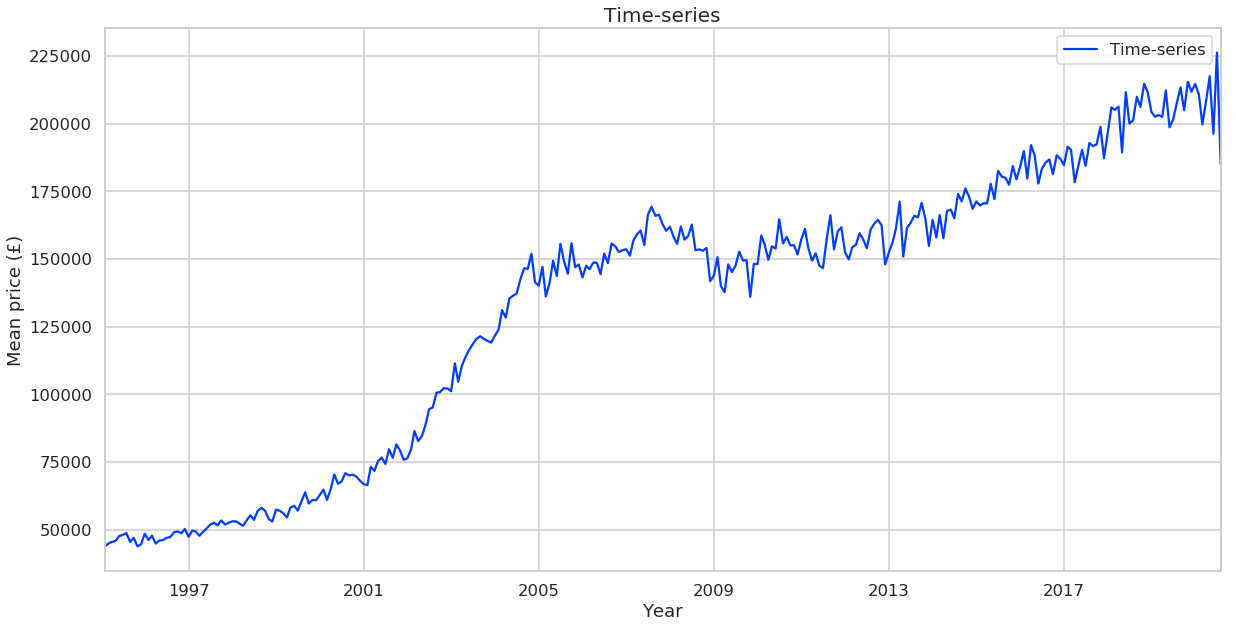

In [12]:
import datetime
import matplotlib.dates as dates
plt.figure(figsize=(20,10))
plt.plot(ts,label='Time-series')
plt.xlim(dates.date2num([ts.index[0], ts.index[-1]]))
plt.xlabel("Year", fontsize='18')
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("Time-series", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

No handles with labels found to put in legend.


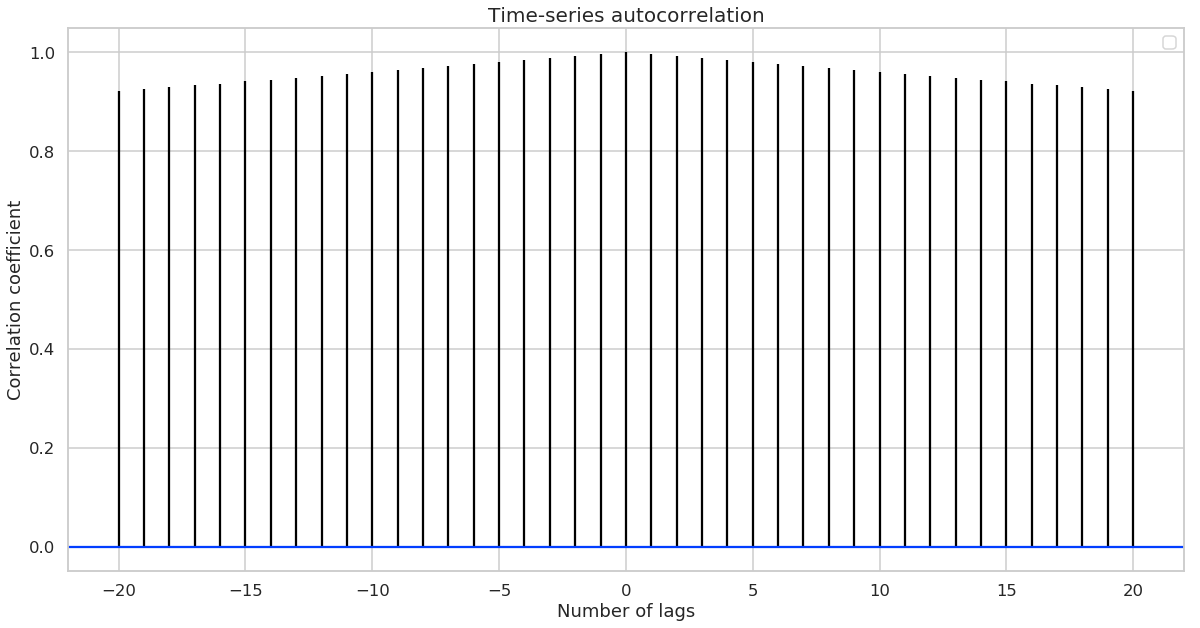

In [13]:
plt.figure(figsize=(20,10))
plt.acorr(x=ts.values,data=ts,maxlags=20)
plt.xlabel("Number of lags", fontsize='18')
plt.ylabel("Correlation coefficient", fontsize='18')
plt.title("Time-series autocorrelation", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()


No handles with labels found to put in legend.


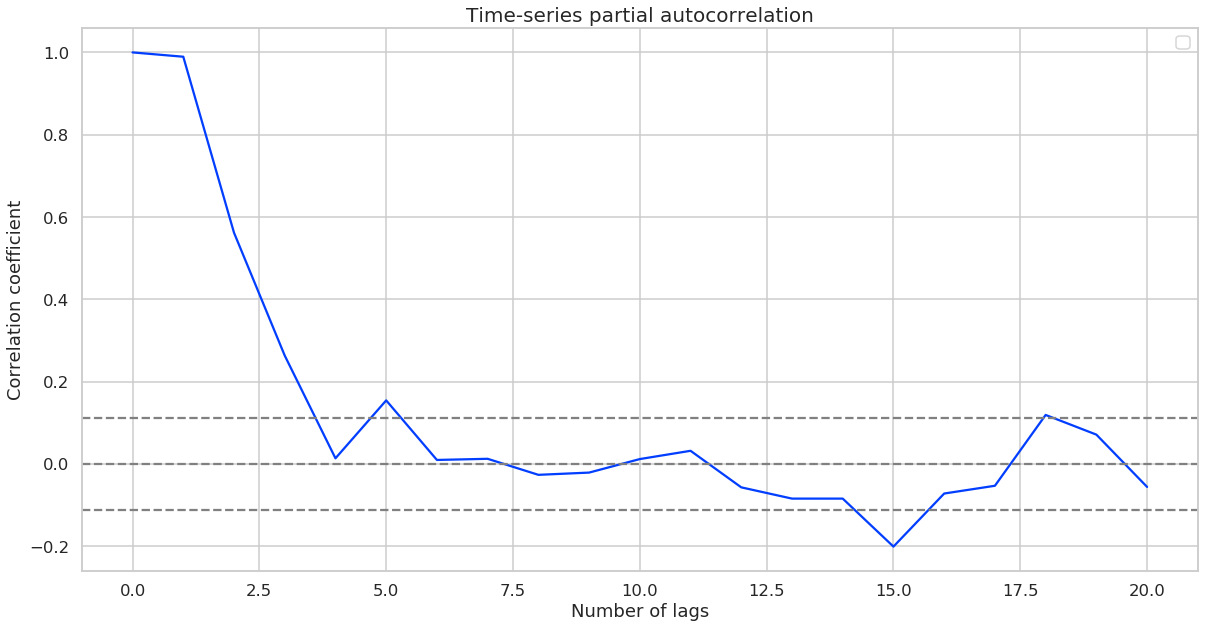

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_pacf=pacf(ts, nlags=20, method='ols')

#plot ACF
plt.figure(figsize=(20,10))
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)), linestyle='--', color='gray')
plt.xlabel("Number of lags", fontsize='18')
plt.ylabel("Correlation coefficient", fontsize='18')
plt.title("Time-series partial autocorrelation",fontsize='20')
plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()


In [15]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
#Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
#Plot rolling statistics:
    plt.figure(figsize=(40,20))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
#Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

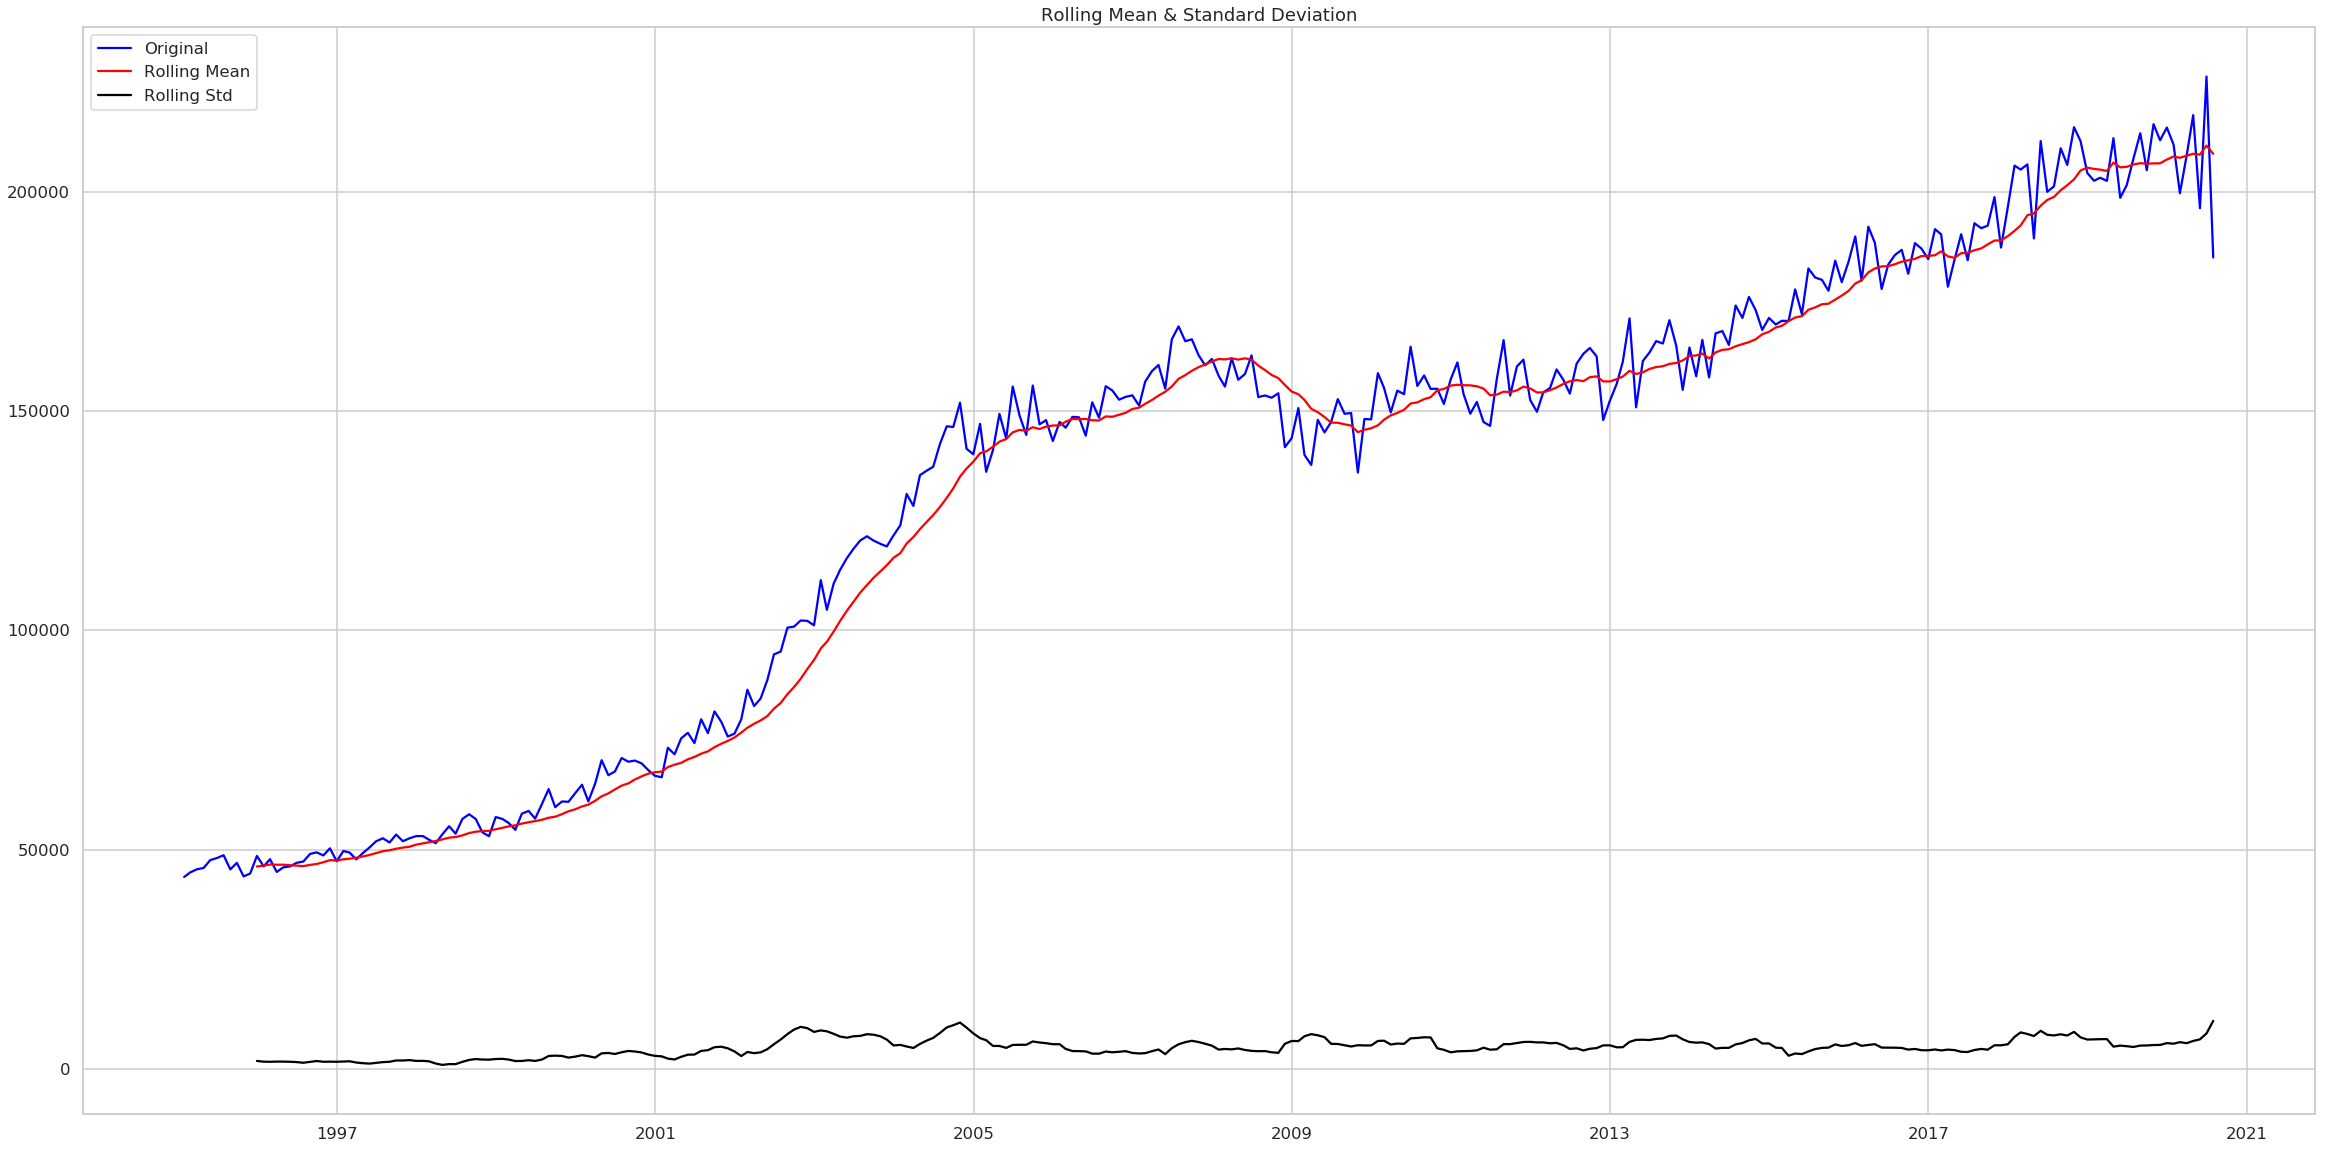

Results of Dickey-Fuller Test:
Test Statistic                  -1.051309
p-value                          0.734094
#Lags Used                       4.000000
Number of Observations Used    302.000000
Critical Value (1%)             -3.452190
Critical Value (5%)             -2.871158
Critical Value (10%)            -2.571895
dtype: float64


In [16]:

test_stationarity(ts)

Time series is not stationary:
- the mean is increasing over time even though the standard deviation is small
- The test statistic is greater thann all critical values, hence we cannot reject the null hypothesis of the data is not stationary at the 99%,95% or 90% level of significance


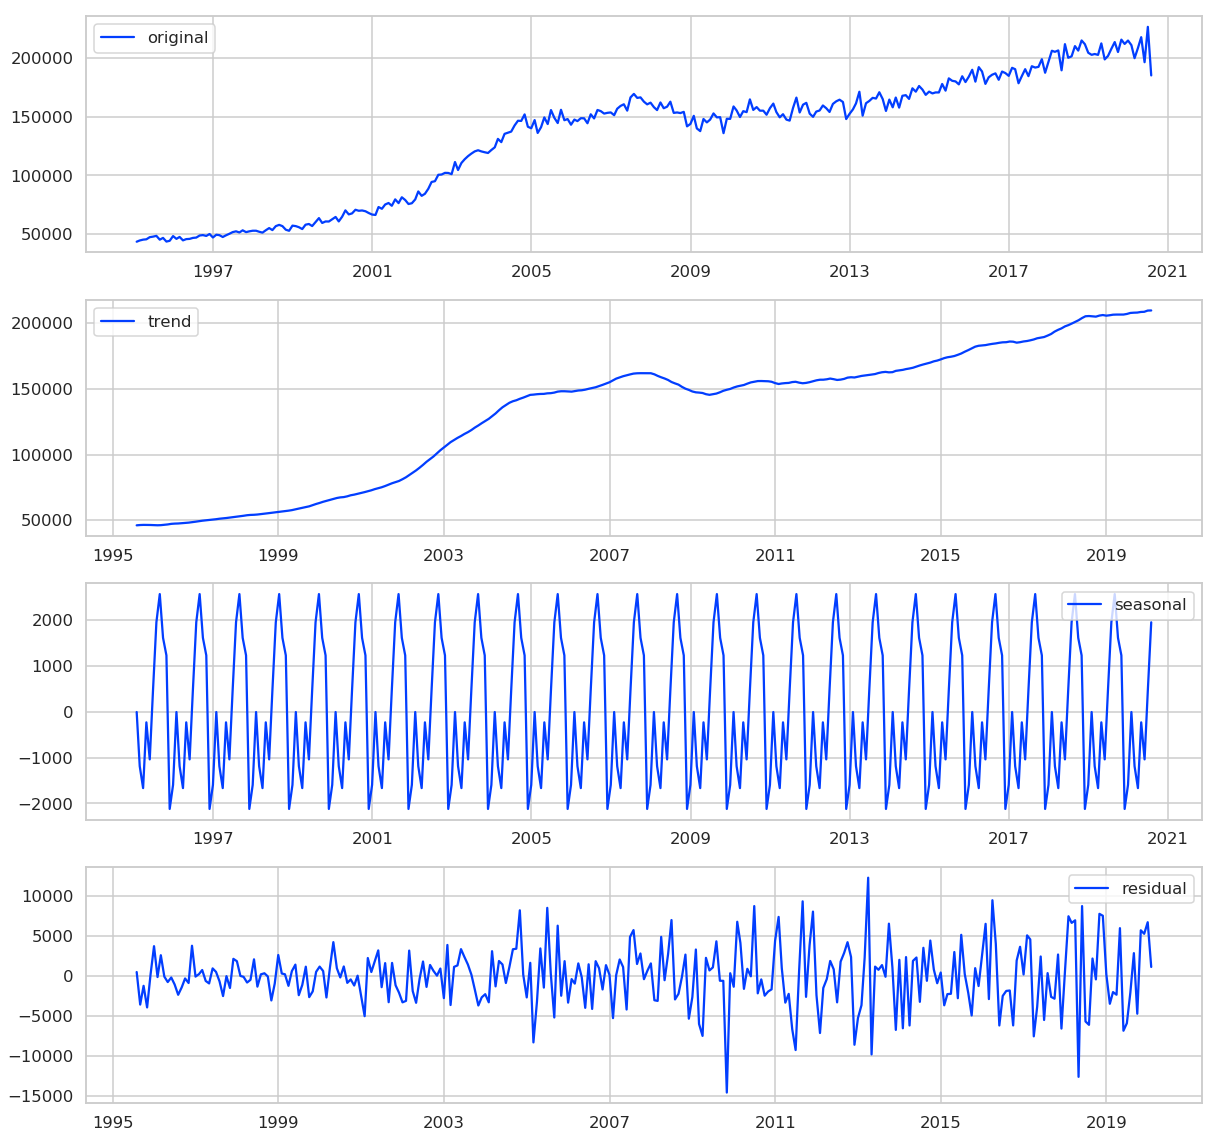

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposistion=seasonal_decompose(ts,freq=12)

trend=decomposistion.trend
seasonal=decomposistion.seasonal
residual=decomposistion.resid
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='residual')
plt.legend(loc='best')


The trend shows that house prices increased at a much quicker rate from 1995-2005 than onwards from 2005, where the rate of increased slowed down and even decreased slightly during 2009 (credit crunch). From 2013 house prices slowly start to increase once more.

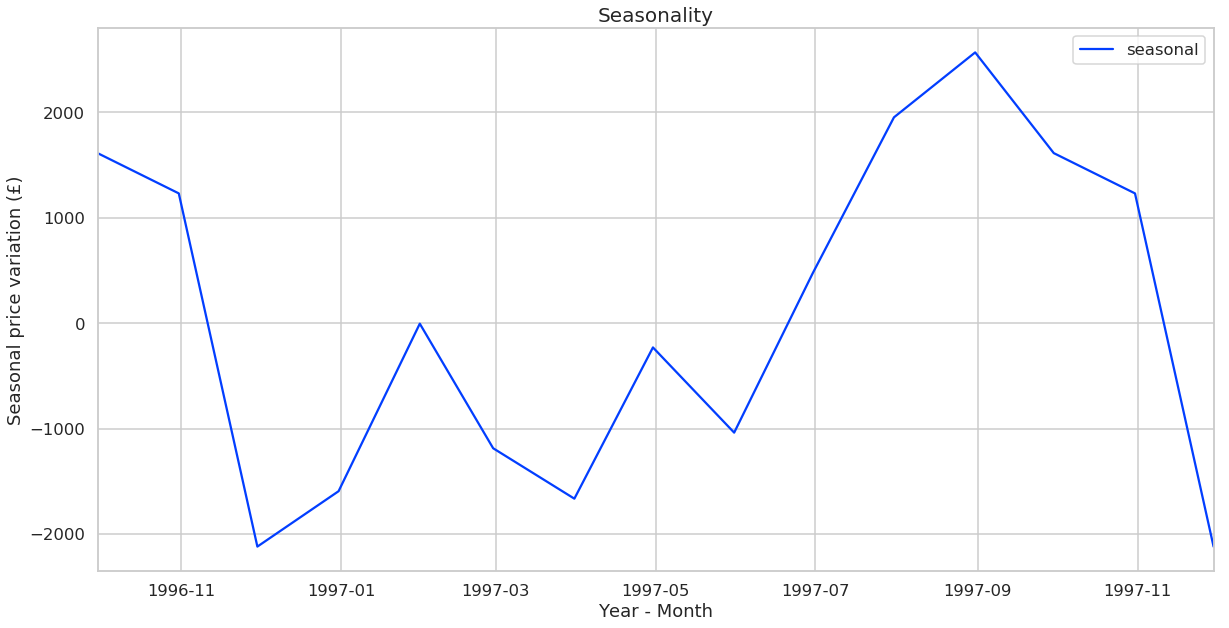

In [18]:
import datetime
import matplotlib.dates as dates
plt.figure(figsize=(20,10))
plt.plot(seasonal,label='seasonal')
plt.xlim(dates.date2num([seasonal.index[20], seasonal.index[34]]))
plt.xlabel("Year - Month", fontsize='18')
plt.ylabel("Seasonal price variation (£)", fontsize='18')
plt.title("Seasonality", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

There is a obvious seasonal trend in the data, with peak prices occuring in August and the lowest during December. Who wants to move house during Christmas time?

In [19]:
# Using groupby to find the seasonal trend for each year
seasonal=seasonal.reset_index()
seasonal['Year']=seasonal['Date'].dt.year
seasonal_year=seasonal.groupby('Year')

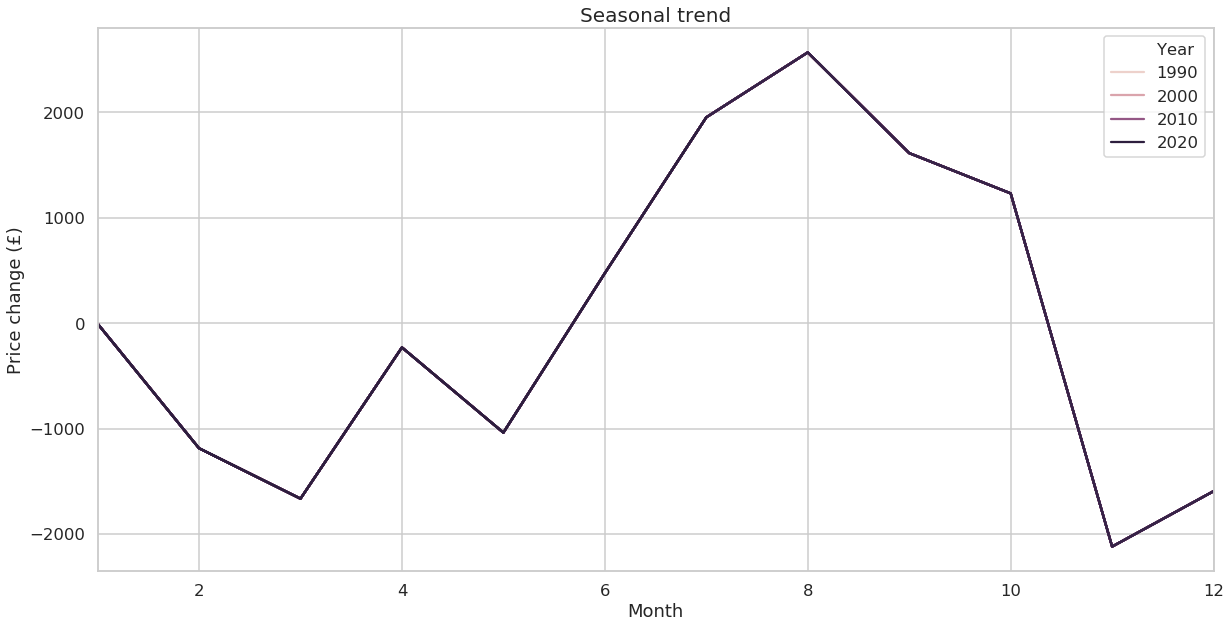

In [20]:
plt.figure(figsize=(20,10))
sns.lineplot(x=(seasonal['Date'].dt.month),y=seasonal['seasonal'],hue='Year',data=seasonal);

plt.xlabel("Month", fontsize='18')
plt.ylabel("Price change (£)", fontsize='18')
plt.title("Seasonal trend", fontsize='20')
plt.xlim([1,12])
plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.legend(loc='best')
plt.show()

From the seasonal trend plot above, it can be seen that the seasonal trend is the same for all years.

In [21]:
#Train-test split, 20 years of training data and 5 years of test data
ts_train=ts[ts.index[0]:( ts.index[ts.index.get_loc('2015-7-30', method='nearest')])]
ts_test=ts[ ts.index[ts.index.get_loc('2015-7-30', method='nearest')]:ts.index[-1]]

The seasonal decomposition method has provided the best results in the Dickey-Fuller test. We can now reject the null hypothesis at a 99% level of confidence. The time-series is now stationary.

In [22]:
# Grid search for optimal SARIMA parameters
from pmdarima.arima import auto_arima
paramsearch=auto_arima(ts_train,start_p=2,d=None,start_q=1,max_p=7,max_d=1,max_q=5,start_P=1
                  ,D=1,start_Q=1,max_P=7,max_D=3,max_Q=7,m=12, trace=True,enforce_stationarity=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4820.433, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4716.587, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4666.609, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4758.847, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4668.068, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4668.048, Time=1.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4703.919, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=7.21 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=1

The grid search finds the best combination of parameters for the ARIMA function. Combinations are rated with their AIC score (lower=better), which is calculated using the models estimation of likelihood. This means the AIC is fully dependant on the training data without any influence from the test data.

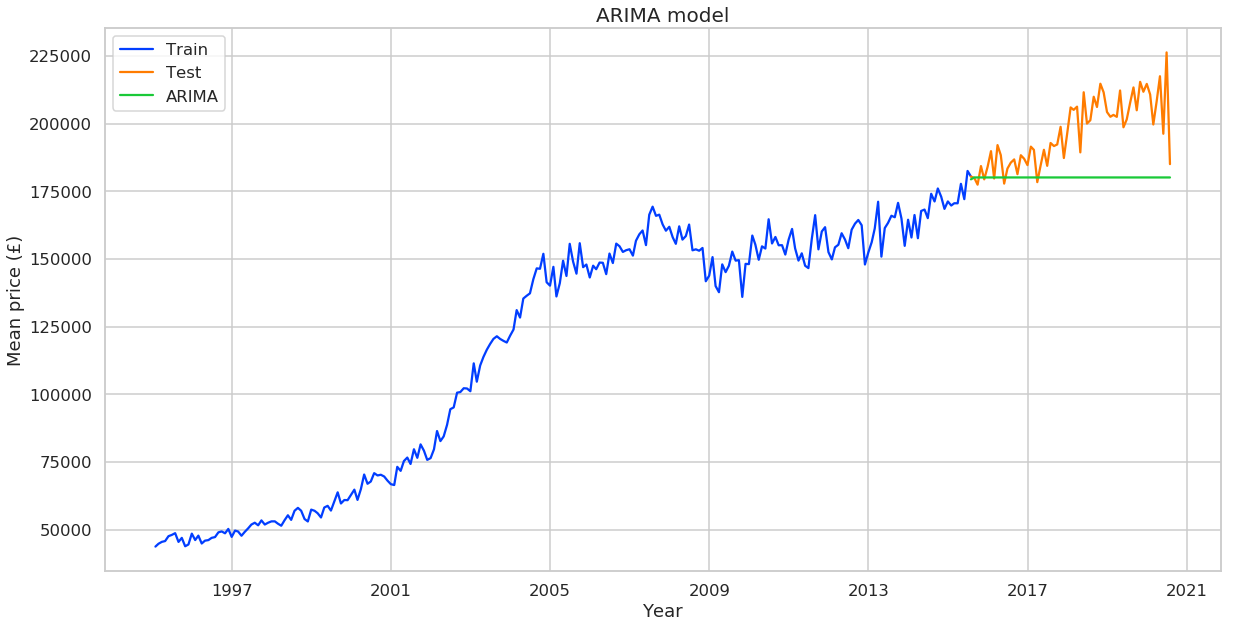

In [23]:
#ARIMA
import statsmodels.api as sm
y_hat_avg = ts_test.copy()
fit1 = sm.tsa.statespace.SARIMAX(ts_train, order=(0, 1, 1),freq='m',seasonal_order=(0,0,0,0)).fit()
y_hat_avg['ARIMA'] = fit1.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.xlabel("Year", fontsize='18')
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("ARIMA model", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.legend(loc='best')
plt.show()

Using the optimal parameters from the grid search without seasonality taken into account, the prediction gives a constant price. This is useless !

In [39]:
fit1.summary()


AttributeError: 'SARIMAXResults' object has no attribute 'AIC'

In [25]:
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(ts_test, y_hat_avg.ARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms, 1)))

The Root Mean Squared Error of our forecasts is 20453.5


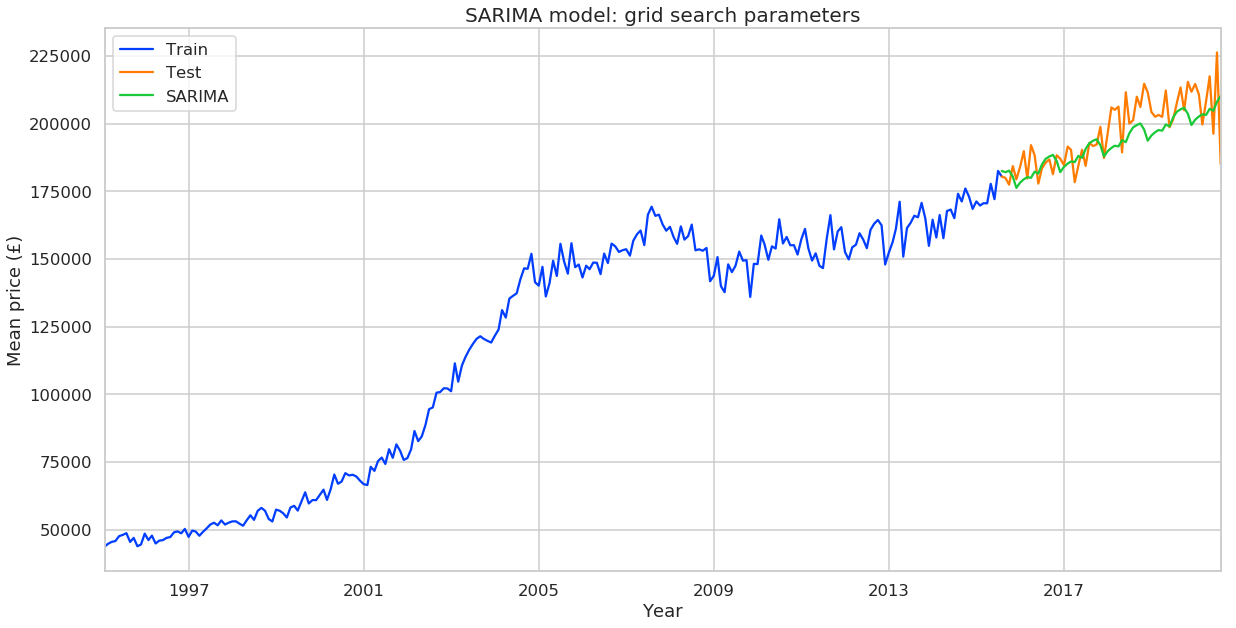

In [26]:
import statsmodels.api as sm
from datetime import datetime
#SARIMA
y_hat_avg = ts_test.copy()
fit2 = sm.tsa.statespace.SARIMAX(ts_train, order=(0, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg['SARIMA'] = fit2.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test.index[-1]]))
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("SARIMA model: grid search parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

With seasonality taken into account, the prediction is no longer constant for each month and fits the test data much better than without seasonality compensation.

In [27]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  247
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2330.305
Date:                            Tue, 06 Oct 2020   AIC                           4666.609
Time:                                    19:43:01   BIC                           4676.975
Sample:                                01-31-1995   HQIC                          4670.789
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4219      0.067     -6.282      0.000      -0.554      -0.290
ma.S.L12      -0.8411      0.078    -10.769      0.000      -0.994      -0.688
sigma2      3.644e+07   3.27e-10   1.11e+17      0.000    3.64e+07    3.64e+07
===================================================================================
Ljung-Box (Q):                       43.26   Jarque-Bera (JB):                 9.47
Prob(Q):                              0.33   Prob(JB):                         0.01
Heteroskedasticity (H):               2.86   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

The AIC without seasonality included is 4861 compared to 4667 when seasonality is taken into account. These values are of similar size, yet the fit of the predicted data to the test data is much different, this shows how the AIC is indepenant of the test data.

In [28]:
from sklearn.metrics import mean_squared_error
rms1 = np.sqrt(mean_squared_error(ts_test, y_hat_avg.SARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms1, 1)))

The Root Mean Squared Error of our forecasts is 8735.0


The RMS error without seasonality is 20396.7, compared to 8735 with seasonality. These numbers are clearly quite different in magnitude with one another, this is because the RMS error is a calculated using the residual of predicted data and the test data.

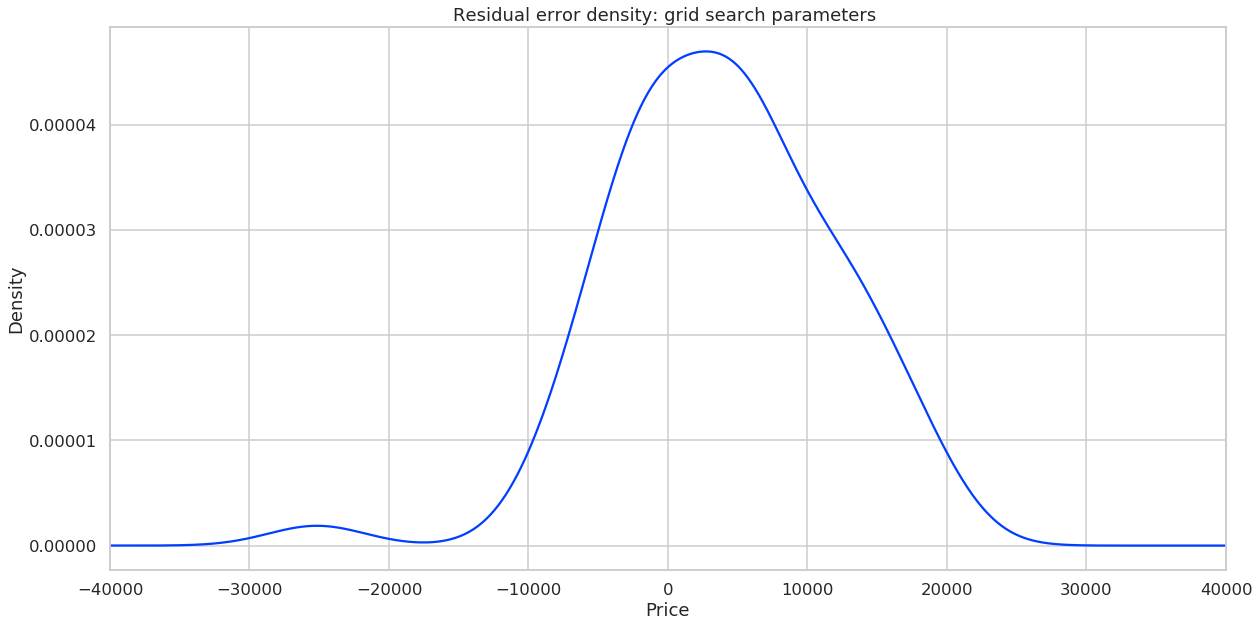

count       61.000000
mean      3842.677726
std       7909.440004
min     -25162.500710
25%      -1391.348788
50%       3892.826278
75%       8657.893132
max      18425.359846
dtype: float64


In [29]:
residuals=ts_test - y_hat_avg['SARIMA']
plt.figure(figsize=(20,10))
residuals.plot(kind='kde')
plt.title('Residual error density: grid search parameters ')
plt.xlabel("Price", fontsize='18')
plt.xlim([-40000,40000])
plt.ylabel("Density", fontsize='18')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()
print(residuals.describe())

As the mean is not centered around 0, the residual error density plot does not follow and normal distribution and hence the errors are not random. The model needs better parameters.

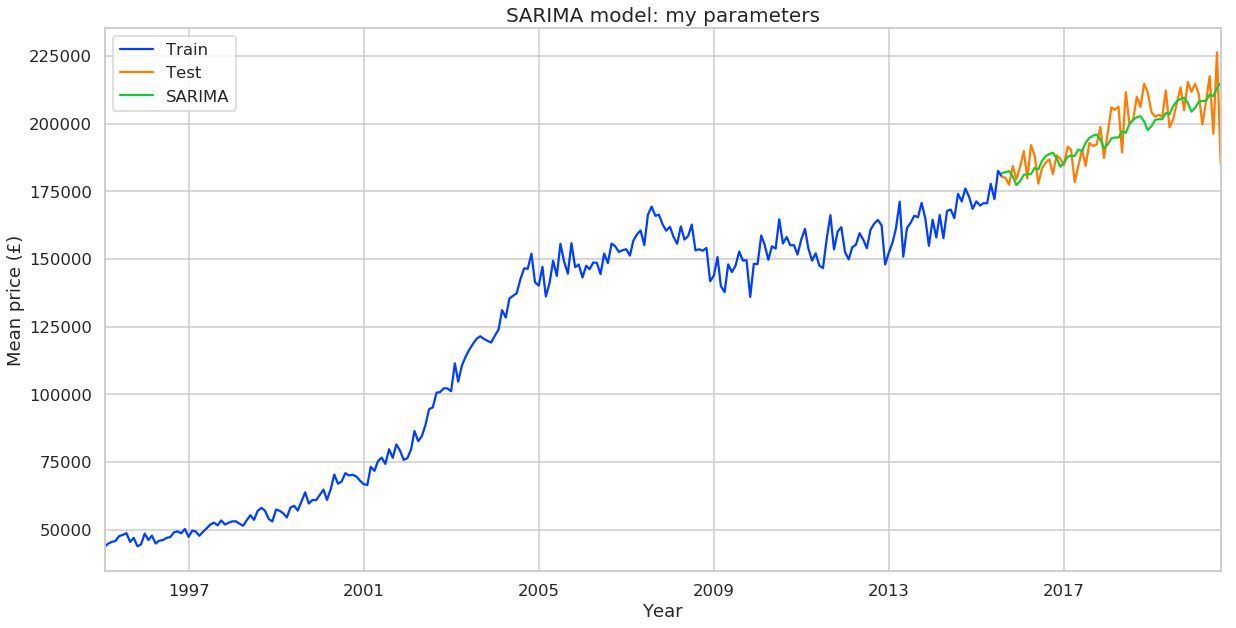

In [30]:
import statsmodels.api as sm
from datetime import datetime
#SARIMA
y_hat_avg1 = ts_test.copy()
fit3 = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg1['SARIMA'] = fit3.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg1['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test.index[-1]]))
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

Having changed the lag order parameter of the SARIMA model (p in (p,d,q)) from 0 to 1, the fit to the test data has improved. This is an example of why AIC should not be used on its own in determing the best model.

In [31]:
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2318.482
Date:                            Tue, 06 Oct 2020   AIC                           4644.964
Time:                                    19:43:05   BIC                           4658.785
Sample:                                01-31-1995   HQIC                          4650.536
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1102      0.142     -0.775      0.438      -0.389       0.168
ma.L1         -0.3286      0.135     -2.430      0.015      -0.594      -0.064
ma.S.L12      -0.9058      0.053    -17.005      0.000      -1.010      -0.801
sigma2      2.212e+07   4.26e-09   5.19e+15      0.000    2.21e+07    2.21e+07
===================================================================================
Ljung-Box (Q):                       44.16   Jarque-Bera (JB):                11.96
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+31. Standard errors may be unstable.
"""

In [32]:
from sklearn.metrics import mean_squared_error
rms2 = np.sqrt(mean_squared_error(ts_test, y_hat_avg1.SARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms2, 1)))

The Root Mean Squared Error of our forecasts is 7679.0


The RMS error has been reduced by over £1000 by changing the lag order parameter from 0 to 1.

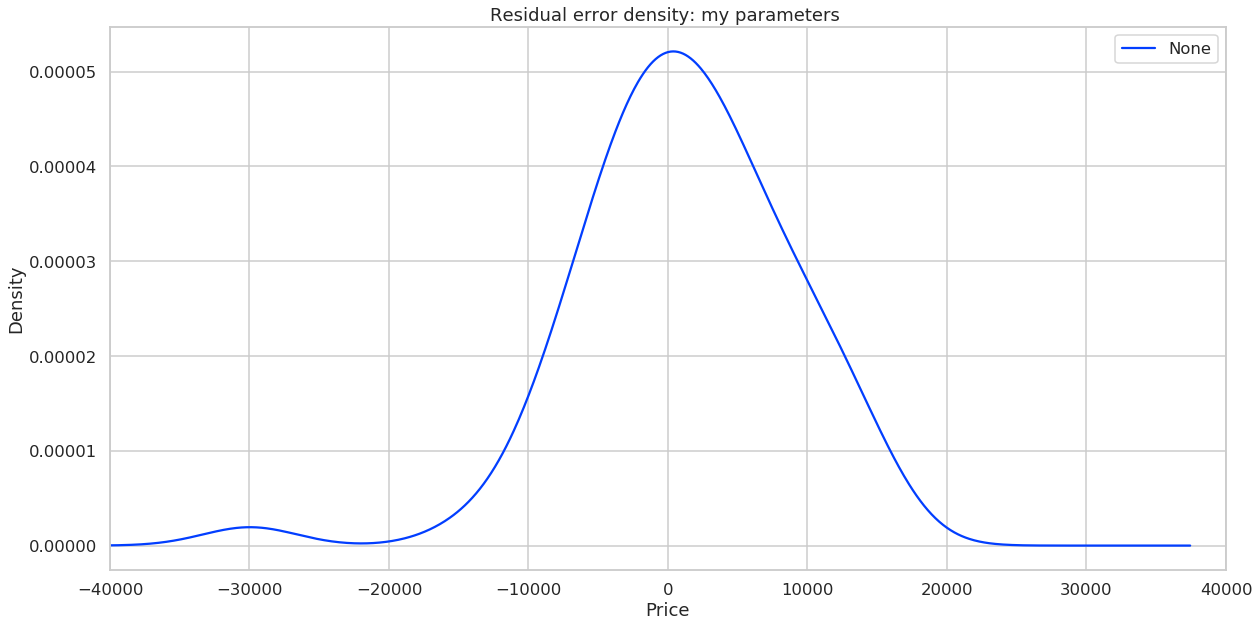

count       61.000000
mean      3842.677726
std       7909.440004
min     -25162.500710
25%      -1391.348788
50%       3892.826278
75%       8657.893132
max      18425.359846
dtype: float64


In [33]:
residuals2=ts_test - y_hat_avg1['SARIMA']
plt.figure(figsize=(20,10))
residuals2.plot(kind='kde')
plt.title('Residual error density: my parameters ')
plt.xlabel("Price", fontsize='18')
plt.xlim([-40000,40000])
plt.ylabel("Density", fontsize='18')
plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()
print(residuals.describe())

The mean is now much closer to 0, although it is still slightly skewed with the line not symmetrical about 0. The bump at -£30,000 shows that the predicted data is under-predicting values by £30,000 more than over-predicting values by £30,000. Overall, the model is over-predicting the prices. This is evident due to there being more area under the graph + x-axis than - x-axis.

Predicting future house prices

In [34]:
#Creating a test date set of future dates
ts_test_future=ts_test
ts_test_future.index=ts_test_future.index+pd.DateOffset(years=5)

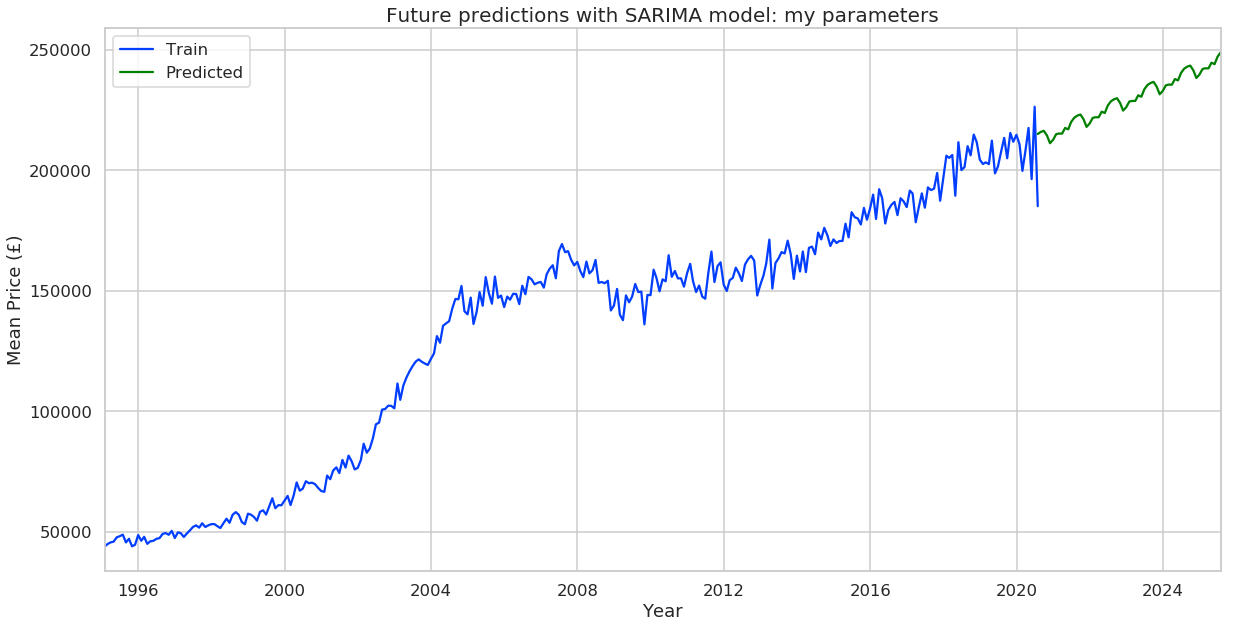

In [35]:
y_hat_avg_future = ts_test_future.copy()
fit_future = sm.tsa.statespace.SARIMAX(ts, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg_future['SARIMA'] = fit3.predict(start=ts_test_future.index[0],end=ts_test_future.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts, label='Train')
plt.plot(y_hat_avg_future['SARIMA'], label='Predicted', color='g')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test_future.index[-1]]))
plt.ylabel("Mean Price (£)", fontsize='18')
plt.title("Future predictions with SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

The future prediction shows an increase in price over 5 years. The rate of increase is constant, apart from the anual seasonality. There are two issues at hand now: I am predicting future prices and I lost the keys to my time machine. This means I have no test data, so the AIC is an approiate criterion to use to evaluate the quality of the model. 

In [36]:
fit_future.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  307
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2973.638
Date:                            Tue, 06 Oct 2020   AIC                           5955.275
Time:                                    19:43:09   BIC                           5970.009
Sample:                                01-31-1995   HQIC                          5961.176
                                     - 07-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2729      0.111     -2.467      0.014      -0.490      -0.056
ma.L1         -0.3518      0.132     -2.665      0.008      -0.611      -0.093
ma.S.L12      -0.8694      0.070    -12.496      0.000      -1.006      -0.733
sigma2      4.787e+07   1.24e-09   3.85e+16      0.000    4.79e+07    4.79e+07
===================================================================================
Ljung-Box (Q):                       45.41   Jarque-Bera (JB):               103.14
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               3.45   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+32. Standard errors may be unstable.
"""

The resultant AIC of the future price predicting model is 5955, compared to a value of 4645 when predicting past prices. This is not what I expected as the future price prediction model uses the whole dataset and therefore has more data fed into the model, rather than the past price prediction model which has less data fed into the model as the data was split for training and testing. 

The reason that this has occured is that one of the assumptions of AIC is that there is an infinte sample size of data and hence the amount of data fed into the model does not have any weight in determining the AIC value.